In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import copy
from collections import namedtuple
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

# Hidden Markov Model Analysis

The most basic way that this problem can be modeled is using graphical hidden markov models.

Let *f* denote females, *m* denote males and *u* denote nodes with an unknown sex. <br>
In addition, let d(.) be a function that returns the latent state size of the input
<br><br>
For every root in the pedigree
$$
f_x \sim \pi_{f_0} \\
m_x \sim \pi_{m_0}
$$
For every child *c* in the pedigree with mother *f* and father *m*
<br>
&nbsp;&nbsp;&nbsp;&nbsp;For i=1...d(f), j=1...d(m), k=1...d(c)
$$
c_{x_k} \sim \pi_{ijk}f_{x_i}m_{x_j} \\
$$
For each node *n*
<br>
&nbsp;&nbsp;&nbsp;&nbsp;For i=1...d(n)
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is female:
$$
n_{y_j} \sim L_{f_ij}n_{x_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is male:
$$
n_{y_j} \sim L_{m_ij}n_{x_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is unknown:
$$
n_{y_j} \sim L_{u_ij}n_{x_i}
$$

Each of the parameters will have a different Dirichlet prior over their last axis.  The root distributions will have a weak prior as there is no way of knowing what their distribution can be and the transition and emission distributions will have priors determined by [Mendelian Inheritance](https://en.wikipedia.org/wiki/Mendelian_inheritance) depending on the model.  The prior (with strength included) will be called *G* and *H* respectively.  There will be an *H* for each different sex
$$
\pi_{\{.\}_0} \sim \text{Dirichlet}( 1 ) \\
\pi_{ij} \sim \text{Dirichlet}(G) \\
L_{\{.\}_i} \sim \text{Dirichlet}(H_{\{.\}})
$$

# Load the dataset.  The feedback sets will be automatically determined

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import PedigreeHMMFilter, PedigreeHMMFilterSexMatters, Pedigree, PedigreeSexMatters
from GenModels.research.Models import *

In [3]:
graphs = load()

Graph 1011MB.json is incorrect. 3
Graph 1038CG.json is incorrect. -1
Graph 1044IO.json is incorrect. -1
Graph 1079JM.json is incorrect. 47
Graph 1083BF.json is incorrect. -1
Graph 2018LM.json is incorrect. -1
Graph 2049EE.json is incorrect. -1
Graph 2068AP.json is incorrect. 18
Graph 235TL.json is incorrect. 1
Graph 273PA.json is incorrect. 3
Graph 3011JB.json is incorrect. Edge before: 1 but tried setting: 2
Graph 3055CG.json is incorrect. -1
Graph 3086GA.json is incorrect. 4
Graph 316CD.json is incorrect. 10
Graph 3200BK.json is incorrect. 1
Graph 3203NZ.json is incorrect. 37
Graph 3216LP.json is incorrect. 13
Graph 3261MM.json is incorrect. 14
Graph 3267NF.json is incorrect. -1
Graph 329JR.json is incorrect. 2
Graph 3379KS.json is incorrect. Edge before: 6 but tried setting: 8
Graph 3420MZ.json is incorrect. 2
Graph 3427NF.json is incorrect. -1
Graph 346GT.json is incorrect. 27
Graph 3507AA.json is incorrect. 1
Graph 3515JA.json is incorrect. 2
Graph 3605JG.json is incorrect. -1
Gra

In [4]:
len( graphs )

430

# Verify that things look as expected

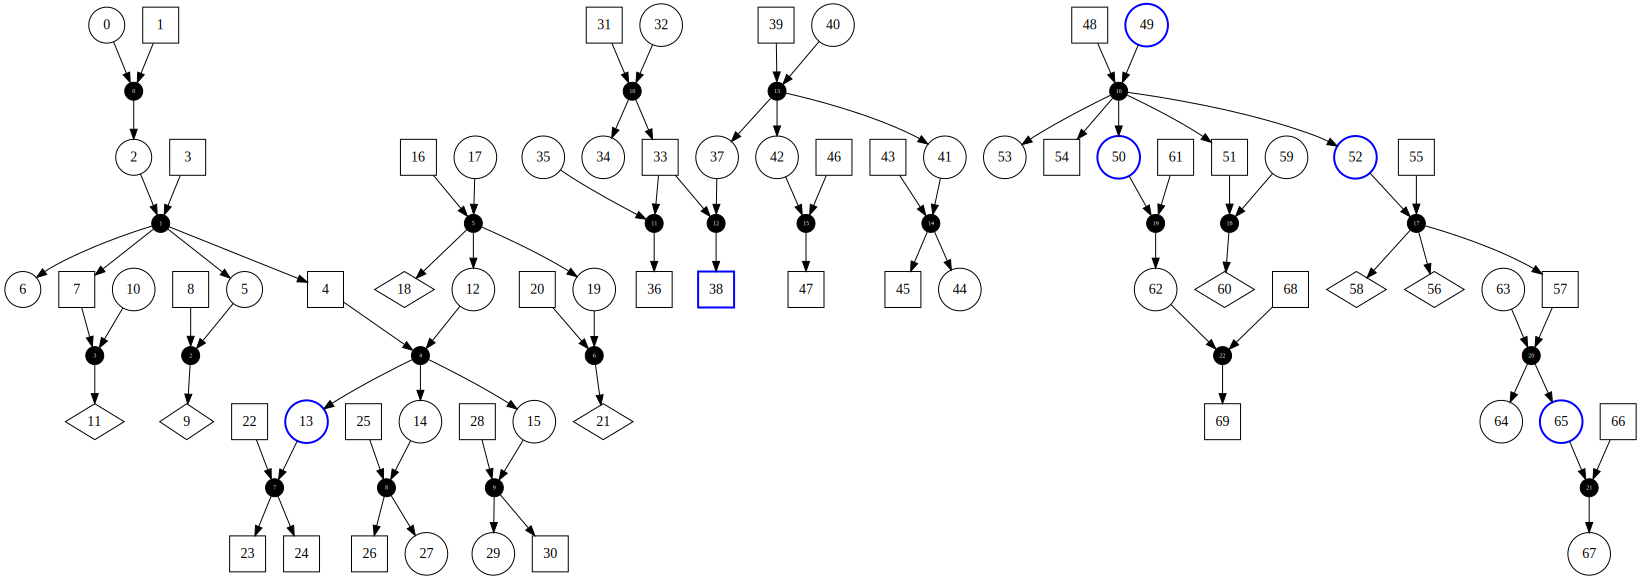

In [5]:
temp = PedigreeHMMFilter()
temp.preprocessData( graphs[ :3 ] )
temp.draw()

# Separate the labeled pedigrees

In [6]:
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]
print( 'Number of graphs for - AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for - AD: 132 AR: 197 XL: 98


# Specify assumptions on the latent states

### An autosomal dominant diagnosis implies that the person has either AA, Aa or aA autosomes, autosomal recessive implies that the person has AA, X-Linked recessive implies that females have XX, males have XY and unknowns have either XX or XY 

In [7]:
def addLatentStateFromDiagnosis( graph, ip_type ):

    if( ip_type == 'AD' ):
        for node in graph.nodes:
            if( graph.data[ node ] == 1 ):
                # Affected
                graph.setPossibleLatentStates( node, [ 0, 1, 2 ] )
    elif( ip_type == 'AR' ):
        for node in graph.nodes:
            if( graph.data[ node ] == 1 ):
                # Affected
                graph.setPossibleLatentStates( node, [ 0 ] )
    elif( ip_type == 'XL' ):
        for node in graph.nodes:
            if( graph.groups[ node ] == 0 ):
                # Female
                if( graph.data[ node ] == 1 ):
                    graph.setPossibleLatentStates( node, [ 0 ] )
            elif( graph.groups[ node ] == 1 ):
                # Male
                if( graph.data[ node ] == 1 ):
                    graph.setPossibleLatentStates( node, [ 0 ] )
            else:
                # Unknown sex
                if( graph.data[ node ] == 1 ):
                    graph.setPossibleLatentStates( node, [ 0, 4 ] )

### Because these are rare diseases, will assume that exactly one root is a carrier.
To do this, will select the root with the most affected descendents.  If there
is a tie, then will use the candidate root with the fewest non-affected descendents.

In [8]:
def selectAffectedRoot( graph ):
    n_affected_below = {}
    n_unaffected_below = {}
    for node in graph.backwardPass():
        n_affected_below[ node ] = 0
        n_unaffected_below[ node ] = 0
        if( graph.data[ node ] == 1 ):
            n_affected_below[ node ] += 1
        else:
            n_unaffected_below[ node ] += 1
        for children in graph.getChildren( node ):
            for child in children:
                if( child in n_affected_below ):
                    n_affected_below[ node ] += n_affected_below[ child ]
                    n_unaffected_below[ node ] += n_unaffected_below[ child ]
                
    n_affected_below_roots = dict( [ ( root, n_affected_below[ root ] ) for root in graph.roots ] )
    n_unaffected_below_roots = dict( [ ( root, n_unaffected_below[ root ] ) for root in graph.roots ] )
    
    max_val = np.max( np.array( list( n_affected_below_roots.values() ) ) )
    selections = [ root for root, val in n_affected_below_roots.items() if val == max_val ]
    
    if( len( selections ) > 1 ):
        # Use n_unaffected_below_roots as a tie breaker
        n_unaffected_below_roots = dict( [ ( root, val ) for root, val in n_unaffected_below_roots.items() if root in selections ] )
        min_val = np.min( np.array( list( n_unaffected_below_roots.values() ) ) )
        selections = [ root for root, val in n_unaffected_below_roots.items() if val == min_val and root in selections ]
        
        # If there are still multiple possibilities, just pick the first one
    return selections[ 0 ]

In [9]:
def sexToCarrierState( graph, node ):
    if( graph.groups[ node ] == 0 ):
        return [ 0, 1, 2 ]
    elif( graph.groups[ node ] == 1 ):
        return [ 0 ]
    elif( graph.groups[ node ] == 2 ):
        return [ 0, 1, 2, 4 ]
    
def sexToNotCarrierState( graph, node ):
    if( graph.groups[ node ] == 0 ):
        return [ 3 ]
    elif( graph.groups[ node ] == 1 ):
        return [ 1 ]
    elif( graph.groups[ node ] == 2 ):
        return [ 3, 5 ]
        
def setGraphRootStates( graph, ip_type ):
    if( ip_type == 'AD' ):
        affected_root = selectAffectedRoot( graph )
        graph.setPossibleLatentStates( affected_root, [ 0, 1, 2 ] )
        for root in filter( lambda x: x!=affected_root, graph.roots ):
            graph.setPossibleLatentStates( root, [ 3 ] )
    elif( ip_type == 'AR' ):
        affected_root = selectAffectedRoot( graph )
        graph.setPossibleLatentStates( affected_root, [ 0, 1, 2 ] )
        for root in filter( lambda x: x!=affected_root, graph.roots ):
            graph.setPossibleLatentStates( root, [ 3 ] )
    elif( ip_type == 'XL' ):
        affected_root = selectAffectedRoot( graph )
        graph.setPossibleLatentStates( affected_root, sexToCarrierState( graph, affected_root ) )
        for root in filter( lambda x: x!=affected_root, graph.roots ):
            graph.setPossibleLatentStates( root, sexToNotCarrierState( graph, root ) )

# Will compare inheritance patterns using E[ P( Θ | Y ) ]

### P( Θ | Y ) ∝ P( Y | Θ )P( Θ )
- When we use a point estimate for P( Θ ), then we can compare P( Θ | Y ) values directly.
- Otherwise, estimate E[ P( Θ | y ) ] using gibbs sampling:
$$
E_{\theta}[ P( \theta | Y ) ] \propto E_{\theta \sim P( \theta | X, Y ) }E_{ X \sim P( X | \theta, Y ) }[ \frac{ P( Y | \theta ) }{ P( X, Y | \theta ) } ]
$$

#### Logic for assumption that XL cannot have male to male transitions

In [10]:
def maleToMale( graph ):
    graph, fbs = graph
    for e, ( parents, children ) in enumerate( zip( graph.edge_parents, graph.edge_children ) ):
        father_affected = [ 1 for parent in parents if graph.attrs[ parent ][ 'sex' ] == 1 and graph.data[ parent ] == 1 ]
        sons_affected = [ 1 for child in children if graph.attrs[ child ][ 'sex' ] == 1 and graph.data[ child ] == 1 ]        
        if( len( father_affected ) > 0 and len( sons_affected ) > 0 ):
            return True
    return False

In [11]:
def evaluationGraphs( graph_and_fbs ):
    
    graph, fbs = graph_and_fbs

    graph_sex_matters = graph if isinstance( graph, PedigreeSexMatters ) else PedigreeSexMatters.fromPedigree( graph )
    graph_sex_doesnt_matters = graph if isinstance( graph, Pedigree ) else Pedigree.fromPedigreeSexMatters( graph )
    
    ad_graph = copy.deepcopy( graph_sex_doesnt_matters )
    ar_graph = copy.deepcopy( graph_sex_doesnt_matters )
    xl_graph = copy.deepcopy( graph_sex_matters )
    
    addLatentStateFromDiagnosis( ad_graph, 'AD' )
    setGraphRootStates( ad_graph, 'AD' )
    
    addLatentStateFromDiagnosis( ar_graph, 'AR' )
    setGraphRootStates( ar_graph, 'AR' )
    
    addLatentStateFromDiagnosis( xl_graph, 'XL' )
    setGraphRootStates( xl_graph, 'XL' )
    
    return ( ad_graph, fbs ), ( ar_graph, fbs ), ( xl_graph, fbs )

## General evaluation

In [47]:
def onlineMeanUpdate( mean, val, N ):
    return mean + ( val - mean ) / N

def normalizedScores( ad_score, ar_score, xl_score ):
    normalizer = np.logaddexp.reduce( [ ad_score, ar_score, xl_score ] )
    probs = np.array( [ np.exp( ad_score - normalizer ), np.exp( ar_score - normalizer ), np.exp( xl_score - normalizer ) ] )
    return probs

def distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=400 ):

    # Fill in assumptions that we can make about each graph
    ad_graph, ar_graph, xl_graph = evaluationGraphs( graph )
    
    # Make the models
    ad_eval = AutosomalDominant( [ ad_graph ], priors=ad_priors, method='Gibbs' )
    ar_eval = AutosomalRecessive( [ ar_graph ], priors=ar_priors, method='Gibbs' )
    xl_eval = XLinkedRecessive( [ xl_graph ], priors=xl_priors, method='Gibbs' )

    # See if there are fathers and sons who are affected to rule out XL
    male_to_male = maleToMale( graph )

    ad_score, ar_score, xl_score = 0.0, 0.0, 0.0
    
    for i in range( samples ):
        
        # Sample Θ
        ad_eval.sampleParams()
        ar_eval.sampleParams()
        xl_eval.sampleParams()
        
        # Update the scores
        ad_score = onlineMeanUpdate( ad_score, ad_eval.marginal(), i+1 )
        ar_score = onlineMeanUpdate( ar_score, ar_eval.marginal(), i+1 )
        if( male_to_male == False ):
            xl_score = onlineMeanUpdate( xl_score, xl_eval.marginal(), i+1 )     
            
    probs = normalizedScores( ad_score, ar_score, xl_score )
    
    # Sort the scores and return the corresponding inheritance pattern
    ad_comp = ( ad_score, 'AD' )
    ar_comp = ( ar_score, 'AR' )
    xl_comp = ( xl_score, 'XL' )
    
    possibilities = [ ad_comp, ar_comp, xl_comp ] if male_to_male == False else [ ad_comp, ar_comp ]
    return sorted( possibilities, key=lambda x: x[ 0 ] )[ -1 ][ 1 ], probs

In [55]:
ad_priors = autosomalDominantPriors( prior_strength=10000.0 )
ar_priors = autosomalRecessivePriors( prior_strength=10000.0 )
xl_priors = xLinkedRecessivePriors( prior_strength=10000.0 )

In [56]:
results = []

In [57]:
N = 300
n_graphs = len( ad_graphs ) + len( ar_graphs ) + len( xl_graphs )
with tqdm( total=n_graphs ) as pbar:
    for graph in ad_graphs:
        ip, probs = distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=N )
        results.append( ( graph, ip, 'AD' ) )
        pbar.update( 1 )
        print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: AD', 'probs', probs )

    for graph in ar_graphs:
        ip, probs = distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=N )
        results.append( ( graph, ip, 'AR' ) )
        pbar.update( 1 )
        print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: AR', 'probs', probs )

    for graph in xl_graphs:
        ip, probs = distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=N )
        results.append( ( graph, ip, 'XL' ) )
        pbar.update( 1 )
        print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: XL', 'probs', probs )

  0%|          | 1/427 [02:23<16:56:16, 143.14s/it]

Study ID 1046DA Prediction: AR True: AD probs [0.32381616 0.40654851 0.26963533]


  0%|          | 2/427 [11:37<31:27:40, 266.50s/it]

Study ID 1084LN Prediction: AR True: AD probs [0.2749757  0.53990556 0.18511875]


  1%|          | 3/427 [17:00<33:22:12, 283.33s/it]

Study ID 189DC Prediction: AD True: AD probs [0.55138346 0.08426046 0.36435608]


  1%|          | 4/427 [19:58<29:36:17, 251.96s/it]

Study ID 2079NC Prediction: AR True: AD probs [0.46941821 0.48970084 0.04088095]


  1%|          | 5/427 [21:29<23:51:58, 203.60s/it]

Study ID 260MG Prediction: AR True: AD probs [0.27817558 0.56074328 0.16108114]


  1%|▏         | 6/427 [24:28<22:56:18, 196.15s/it]

Study ID 3009DD Prediction: AD True: AD probs [0.56902768 0.32114239 0.10982993]


  2%|▏         | 7/427 [29:14<26:02:21, 223.19s/it]

Study ID 3075EZ Prediction: AR True: AD probs [0.46289177 0.51811588 0.01899236]


  2%|▏         | 8/427 [32:02<24:02:19, 206.54s/it]

Study ID 3183DG Prediction: AD True: AD probs [0.64348466 0.31831847 0.03819687]


  2%|▏         | 9/427 [38:38<30:34:26, 263.32s/it]

Study ID 3235JW Prediction: AD True: AD probs [0.6744165  0.12995237 0.19563113]


  2%|▏         | 10/427 [42:17<28:58:39, 250.17s/it]

Study ID 3638NW Prediction: AD True: AD probs [0.43107672 0.40839682 0.16052647]


  3%|▎         | 11/427 [45:34<27:04:01, 234.24s/it]

Study ID 3726LN Prediction: AR True: AD probs [0.4012284  0.50847052 0.09030108]


  3%|▎         | 12/427 [49:20<26:42:56, 231.75s/it]

Study ID 3738KW Prediction: XL True: AD probs [0.38899157 0.10286141 0.50814702]


  3%|▎         | 13/427 [52:52<25:58:46, 225.91s/it]

Study ID 374CR Prediction: AD True: AD probs [0.445342   0.12360287 0.43105513]


  3%|▎         | 14/427 [57:03<26:46:47, 233.43s/it]

Study ID 3814CB Prediction: AR True: AD probs [0.31395166 0.6283924  0.05765594]


  4%|▎         | 15/427 [1:03:26<31:50:31, 278.23s/it]

Study ID 3930EM Prediction: AD True: AD probs [0.67954977 0.30773644 0.01271378]


  4%|▎         | 16/427 [1:09:03<33:47:19, 295.96s/it]

Study ID 3935SC Prediction: AR True: AD probs [0.34648598 0.36248056 0.29103347]


  4%|▍         | 17/427 [1:14:05<33:52:45, 297.48s/it]

Study ID 3951WI Prediction: AD True: AD probs [0.53947218 0.07289123 0.38763659]


  4%|▍         | 18/427 [1:16:29<28:35:26, 251.65s/it]

Study ID 3962TD Prediction: AR True: AD probs [0.28368359 0.4349373  0.28137911]


  4%|▍         | 19/427 [1:18:57<24:58:28, 220.36s/it]

Study ID 396WP Prediction: AD True: AD probs [0.65386206 0.2662926  0.07984533]


  5%|▍         | 20/427 [1:21:09<21:55:14, 193.89s/it]

Study ID 417CP Prediction: XL True: AD probs [0.31033885 0.16438726 0.52527389]


  5%|▍         | 21/427 [1:25:15<23:38:52, 209.69s/it]

Study ID 4210AW Prediction: AR True: AD probs [0.17887916 0.79694446 0.02417639]


  5%|▌         | 22/427 [1:28:16<22:36:46, 201.00s/it]

Study ID 4235CD Prediction: AD True: AD probs [0.81997338 0.11388726 0.06613936]


  5%|▌         | 23/427 [1:32:48<24:55:55, 222.17s/it]

Study ID 4256JT Prediction: AD True: AD probs [0.45271313 0.24249603 0.30479084]


  6%|▌         | 24/427 [1:36:19<24:31:37, 219.10s/it]

Study ID 4272DG Prediction: AD True: AD probs [0.66954224 0.20308911 0.12736865]


  6%|▌         | 25/427 [1:38:28<21:26:28, 192.01s/it]

Study ID 4363LR Prediction: AD True: AD probs [0.71137111 0.15722725 0.13140164]


  6%|▌         | 26/427 [1:40:47<19:37:08, 176.13s/it]

Study ID 4460TK Prediction: AD True: AD probs [0.80966596 0.05809608 0.13223795]


  6%|▋         | 27/427 [1:43:23<18:53:24, 170.01s/it]

Study ID 4599LB Prediction: AD True: AD probs [0.58797983 0.3159873  0.09603286]


  7%|▋         | 28/427 [1:47:55<22:14:43, 200.71s/it]

Study ID  Prediction: AD True: AD probs [0.72621168 0.25456598 0.01922234]


  7%|▋         | 29/427 [1:57:26<34:27:41, 311.71s/it]

Study ID 4660FF Prediction: AD True: AD probs [0.91745315 0.05346726 0.0290796 ]


  7%|▋         | 30/427 [2:00:55<30:57:24, 280.72s/it]

Study ID 4747ZR Prediction: AD True: AD probs [0.7704846  0.18416376 0.04535164]


  7%|▋         | 31/427 [2:04:34<28:51:52, 262.40s/it]

Study ID 4754LK Prediction: AD True: AD probs [0.97111151 0.01858543 0.01030306]


  7%|▋         | 32/427 [2:09:15<29:24:35, 268.04s/it]

Study ID 4781RM Prediction: AD True: AD probs [0.84040941 0.10212869 0.05746189]


  8%|▊         | 33/427 [2:11:16<24:30:24, 223.92s/it]

Study ID 4951DK Prediction: XL True: AD probs [0.3611448  0.23109934 0.40775586]


  8%|▊         | 34/427 [2:14:01<22:30:40, 206.21s/it]

Study ID 4954DK Prediction: AR True: AD probs [0.40461366 0.45687335 0.138513  ]


  8%|▊         | 35/427 [2:18:04<23:39:45, 217.31s/it]

Study ID 4978SS Prediction: AD True: AD probs [0.54875093 0.30891256 0.14233652]


  8%|▊         | 36/427 [2:22:14<24:39:30, 227.04s/it]

Study ID 4982RL Prediction: AR True: AD probs [0.10969787 0.49684098 0.39346115]


  9%|▊         | 37/427 [2:25:35<23:44:07, 219.10s/it]

Study ID 5045DH Prediction: AR True: AD probs [0.388059   0.39852111 0.2134199 ]


  9%|▉         | 38/427 [2:27:38<20:33:12, 190.21s/it]

Study ID 5046IL Prediction: AD True: AD probs [0.59153944 0.21358127 0.19487929]


  9%|▉         | 39/427 [2:28:05<15:13:33, 141.27s/it]

Study ID 506JA Prediction: AD True: AD probs [0.40826737 0.31451182 0.27722081]


  9%|▉         | 40/427 [2:31:45<17:44:42, 165.07s/it]

Study ID 5238JB Prediction: AD True: AD probs [0.43628779 0.34075997 0.22295223]


 10%|▉         | 41/427 [2:36:45<22:01:48, 205.46s/it]

Study ID 5248RH Prediction: AD True: AD probs [0.48106675 0.40682783 0.11210542]


 10%|▉         | 42/427 [2:43:53<29:07:33, 272.35s/it]

Study ID 5252SR Prediction: AD True: AD probs [0.99426077 0.00248509 0.00325414]


 10%|█         | 43/427 [2:48:47<29:43:48, 278.72s/it]

Study ID 5263TS Prediction: AR True: AD probs [0.27621426 0.70331072 0.02047502]


 10%|█         | 44/427 [2:52:43<28:16:30, 265.77s/it]

Study ID 5273BR Prediction: AD True: AD probs [0.60718743 0.3164208  0.07639177]


 11%|█         | 45/427 [2:55:35<25:13:52, 237.78s/it]

Study ID 5348DW Prediction: AD True: AD probs [0.59707094 0.29411996 0.1088091 ]


 11%|█         | 46/427 [2:58:31<23:12:53, 219.35s/it]

Study ID 5349AW Prediction: AD True: AD probs [0.62107164 0.22901922 0.14990913]


 11%|█         | 47/427 [3:02:44<24:13:14, 229.46s/it]

Study ID 5359MH Prediction: AR True: AD probs [0.20740653 0.50858433 0.28400914]


 11%|█         | 48/427 [3:08:04<27:00:51, 256.60s/it]

Study ID 5393JR Prediction: AR True: AD probs [0.06190702 0.9302683  0.00782468]


 11%|█▏        | 49/427 [3:12:41<27:33:35, 262.48s/it]

Study ID 5543ES Prediction: AD True: AD probs [0.52705747 0.28281158 0.19013096]


 12%|█▏        | 50/427 [3:15:15<24:06:19, 230.18s/it]

Study ID 5571JF Prediction: AD True: AD probs [0.6547494  0.30871562 0.03653498]


 12%|█▏        | 51/427 [3:16:44<19:36:54, 187.80s/it]

Study ID 5633JK Prediction: AR True: AD probs [0.36394514 0.40146536 0.2345895 ]


 12%|█▏        | 52/427 [3:19:12<18:17:57, 175.67s/it]

Study ID 5665PB Prediction: AR True: AD probs [0.34616744 0.45070725 0.20312531]


 12%|█▏        | 53/427 [3:21:31<17:06:51, 164.74s/it]

Study ID 5775VS Prediction: AD True: AD probs [0.43506736 0.40049283 0.16443981]


 13%|█▎        | 54/427 [3:25:18<18:59:56, 183.37s/it]

Study ID 5783CC Prediction: AR True: AD probs [0.09307393 0.56746652 0.33945956]


 13%|█▎        | 55/427 [3:26:55<16:16:32, 157.51s/it]

Study ID 5808SL Prediction: AD True: AD probs [0.73568768 0.11628123 0.14803109]


 13%|█▎        | 56/427 [3:29:10<15:31:42, 150.68s/it]

Study ID 5864KJ Prediction: AD True: AD probs [0.61038215 0.29018832 0.09942953]


 13%|█▎        | 57/427 [3:32:52<17:42:25, 172.29s/it]

Study ID 5867KA Prediction: XL True: AD probs [0.0668129  0.12920607 0.80398103]


 14%|█▎        | 58/427 [3:36:44<19:29:11, 190.11s/it]

Study ID 5892JB Prediction: AR True: AD probs [0.13838688 0.73755959 0.12405353]


 14%|█▍        | 59/427 [3:40:01<19:37:53, 192.05s/it]

Study ID 5904SC Prediction: AD True: AD probs [0.71508061 0.1602733  0.12464609]


 14%|█▍        | 60/427 [3:48:10<28:40:33, 281.29s/it]

Study ID 5961FY Prediction: AD True: AD probs [0.59494281 0.08902929 0.3160279 ]


 14%|█▍        | 61/427 [3:56:20<34:57:24, 343.84s/it]

Study ID 5962WJ Prediction: AD True: AD probs [0.52080522 0.35246052 0.12673425]


 15%|█▍        | 62/427 [3:58:17<27:57:21, 275.73s/it]

Study ID 5965MS Prediction: AR True: AD probs [0.35990728 0.39826106 0.24183166]


 15%|█▍        | 63/427 [4:01:37<25:34:52, 253.00s/it]

Study ID 6087SR Prediction: AD True: AD probs [0.75434757 0.02584161 0.21981082]


 15%|█▍        | 64/427 [4:03:50<21:53:22, 217.09s/it]

Study ID 6156AK Prediction: AR True: AD probs [0.41555653 0.46479352 0.11964995]


 15%|█▌        | 65/427 [4:06:12<19:34:33, 194.68s/it]

Study ID 6212SD Prediction: AD True: AD probs [0.44560618 0.39438299 0.16001083]


 15%|█▌        | 66/427 [4:09:50<20:12:52, 201.59s/it]

Study ID 6323AM Prediction: AD True: AD probs [0.62658664 0.35784172 0.01557164]


 16%|█▌        | 67/427 [4:15:57<25:06:32, 251.09s/it]

Study ID 6339KS Prediction: AR True: AD probs [0.00428646 0.96719142 0.02852212]


 16%|█▌        | 68/427 [4:18:33<22:13:01, 222.79s/it]

Study ID 643SB Prediction: AD True: AD probs [0.73941063 0.17865788 0.08193149]


 16%|█▌        | 69/427 [4:21:10<20:10:53, 202.94s/it]

Study ID 6481MR Prediction: AR True: AD probs [0.38199577 0.44691282 0.17109142]


 16%|█▋        | 70/427 [4:23:31<18:16:34, 184.30s/it]

Study ID 843BC Prediction: AR True: AD probs [0.38557526 0.48411133 0.1303134 ]


 17%|█▋        | 71/427 [4:24:48<15:02:01, 152.03s/it]

Study ID 849SS Prediction: AD True: AD probs [0.51985114 0.29023691 0.18991194]


 17%|█▋        | 72/427 [4:29:17<18:28:11, 187.30s/it]

Study ID 852BB Prediction: AD True: AD probs [0.61902003 0.20583315 0.17514682]


 17%|█▋        | 73/427 [4:31:54<17:30:39, 178.08s/it]

Study ID 918TB Prediction: AD True: AD probs [0.87228459 0.07932972 0.04838569]


 17%|█▋        | 74/427 [4:34:30<16:49:03, 171.51s/it]

Study ID 919KB Prediction: AD True: AD probs [0.87659322 0.10995303 0.01345375]


 18%|█▊        | 75/427 [4:37:38<17:15:04, 176.43s/it]

Study ID 951RP Prediction: AD True: AD probs [0.83883857 0.0714652  0.08969623]


 18%|█▊        | 76/427 [4:39:28<15:16:13, 156.62s/it]

Study ID 988FT Prediction: AD True: AD probs [0.49035305 0.32229272 0.18735423]


 18%|█▊        | 77/427 [4:41:29<14:10:08, 145.74s/it]

Study ID 989NT Prediction: AR True: AD probs [0.37196718 0.43637337 0.19165945]


 18%|█▊        | 78/427 [4:43:58<14:13:44, 146.78s/it]

Study ID 991KH Prediction: AD True: AD probs [0.8222963  0.09790854 0.07979515]


 19%|█▊        | 79/427 [4:47:25<15:56:56, 164.99s/it]

Study ID NEI_INVAJ998CWH Prediction: AD True: AD probs [0.49321855 0.3817247  0.12505675]


 19%|█▊        | 80/427 [4:49:34<14:50:32, 153.98s/it]

Study ID NEI_INVAM138NTX Prediction: AR True: AD probs [0.21819663 0.59892511 0.18287825]


 19%|█▉        | 81/427 [4:51:58<14:31:57, 151.21s/it]

Study ID NEI_INVBB998CWA Prediction: AR True: AD probs [0.28936555 0.55214196 0.15849249]


 19%|█▉        | 82/427 [4:52:44<11:27:05, 119.49s/it]

Study ID NEI_INVBD595HCN Prediction: AD True: AD probs [0.54495371 0.2414131  0.21363319]


 19%|█▉        | 83/427 [4:57:16<15:47:09, 165.20s/it]

Study ID NEI_INVCA368YDV Prediction: AD True: AD probs [0.6971262  0.16044552 0.14242828]


 20%|█▉        | 84/427 [4:58:01<12:19:23, 129.34s/it]

Study ID NEI_INVCD787DYL Prediction: AD True: AD probs [0.50854919 0.31474432 0.17670649]


 20%|█▉        | 85/427 [5:05:20<21:07:01, 222.28s/it]

Study ID NEI_INVCF058JDH Prediction: AD True: AD probs [0.77498562 0.09909184 0.12592254]


 20%|██        | 86/427 [5:07:19<18:07:04, 191.28s/it]

Study ID NEI_INVCM100CNM Prediction: AD True: AD probs [0.35677297 0.34045407 0.30277295]


 20%|██        | 87/427 [5:09:15<15:54:30, 168.44s/it]

Study ID NEI_INVCN074DA1 Prediction: AD True: AD probs [0.63224396 0.12788721 0.23986883]


 21%|██        | 88/427 [5:13:02<17:32:31, 186.29s/it]

Study ID NEI_INVDB264FHL Prediction: AD True: AD probs [0.52259315 0.44756363 0.02984323]


 21%|██        | 89/427 [5:14:25<14:33:48, 155.11s/it]

Study ID NEI_INVDH120NAP Prediction: AD True: AD probs [0.42962107 0.3820285  0.18835043]


 21%|██        | 90/427 [5:16:10<13:07:05, 140.14s/it]

Study ID NEI_INVDP757JH0 Prediction: AD True: AD probs [0.51126831 0.36342917 0.12530252]


 21%|██▏       | 91/427 [5:18:45<13:29:29, 144.55s/it]

Study ID NEI_INVDV551CK8 Prediction: AD True: AD probs [0.85353356 0.09606723 0.05039921]


 22%|██▏       | 92/427 [5:20:22<12:06:46, 130.17s/it]

Study ID NEI_INVEK698MP1 Prediction: AD True: AD probs [0.5108812  0.30522414 0.18389466]


 22%|██▏       | 93/427 [5:27:25<20:14:46, 218.22s/it]

Study ID NEI_INVEN150MG6 Prediction: AD True: AD probs [0.89278    0.08941708 0.01780291]


 22%|██▏       | 94/427 [5:28:46<16:21:43, 176.89s/it]

Study ID NEI_INVEP077KRQ Prediction: AD True: AD probs [0.55076309 0.27621008 0.17302683]


 22%|██▏       | 95/427 [5:31:14<15:31:41, 168.38s/it]

Study ID NEI_INVER365TNE Prediction: AD True: AD probs [0.81428697 0.13787888 0.04783415]


 22%|██▏       | 96/427 [5:34:08<15:37:09, 169.88s/it]

Study ID NEI_INVFF850PPA Prediction: AD True: AD probs [0.7130638  0.23287451 0.05406169]


 23%|██▎       | 97/427 [5:36:36<14:59:34, 163.56s/it]

Study ID NEI_INVGB238BTY Prediction: AD True: AD probs [0.72592957 0.22601829 0.04805214]


 23%|██▎       | 98/427 [5:43:15<21:22:52, 233.96s/it]

Study ID NEI_INVHE305BX1 Prediction: AD True: AD probs [0.83800891 0.14840059 0.01359049]


 23%|██▎       | 99/427 [5:50:00<26:00:32, 285.46s/it]

Study ID NEI_INVHG282EN1 Prediction: AD True: AD probs [0.96448357 0.00288194 0.03263449]


 23%|██▎       | 100/427 [5:52:26<22:07:47, 243.63s/it]

Study ID NEI_INVJJ165DPE Prediction: AD True: AD probs [0.56614398 0.27016231 0.16369372]


 24%|██▎       | 101/427 [5:54:23<18:36:56, 205.57s/it]

Study ID NEI_INVKE437DH4 Prediction: AD True: AD probs [0.38509687 0.36263888 0.25226425]


 24%|██▍       | 102/427 [5:55:14<14:22:13, 159.18s/it]

Study ID NEI_INVKH434EWG Prediction: AD True: AD probs [0.46638137 0.35251402 0.18110461]


 24%|██▍       | 103/427 [5:58:22<15:07:06, 167.98s/it]

Study ID NEI_INVKP170XZH Prediction: AD True: AD probs [0.66445517 0.21807801 0.11746683]


 24%|██▍       | 104/427 [6:03:22<18:37:21, 207.56s/it]

Study ID NEI_INVLD241ET1 Prediction: AD True: AD probs [0.47008462 0.43395285 0.09596253]


 25%|██▍       | 105/427 [6:10:07<23:51:25, 266.72s/it]

Study ID NEI_INVLG919LXT Prediction: AD True: AD probs [0.98161505 0.00679055 0.01159441]


 25%|██▍       | 106/427 [6:12:35<20:36:52, 231.19s/it]

Study ID NEI_INVLR991GGT Prediction: AD True: AD probs [0.79518013 0.1639801  0.04083978]


 25%|██▌       | 107/427 [6:14:14<17:00:43, 191.39s/it]

Study ID NEI_INVLT754ZDU Prediction: AR True: AD probs [0.31456233 0.38445354 0.30098413]


 25%|██▌       | 108/427 [6:18:38<18:52:47, 213.06s/it]

Study ID NEI_INVLU847DCX Prediction: AD True: AD probs [0.89663729 0.05249886 0.05086385]


 26%|██▌       | 109/427 [6:21:15<17:21:21, 196.48s/it]

Study ID NEI_INVMD108DNV Prediction: AD True: AD probs [0.58241679 0.38390518 0.03367804]


 26%|██▌       | 110/427 [6:23:21<15:26:34, 175.38s/it]

Study ID NEI_INVMK735EA3 Prediction: XL True: AD probs [0.34835634 0.26232596 0.3893177 ]


 26%|██▌       | 111/427 [6:25:54<14:46:58, 168.41s/it]

Study ID NEI_INVMT995EXP Prediction: AR True: AD probs [0.34027117 0.38486631 0.27486252]


 26%|██▌       | 112/427 [6:32:38<20:56:17, 239.29s/it]

Study ID NEI_INVPM894DVL Prediction: AD True: AD probs [0.82347536 0.16445959 0.01206506]


 26%|██▋       | 113/427 [6:39:41<25:39:40, 294.21s/it]

Study ID NEI_INVPW823HD8 Prediction: AD True: AD probs [0.88328086 0.02146411 0.09525504]


 27%|██▋       | 114/427 [6:42:49<22:48:28, 262.33s/it]

Study ID NEI_INVRL483BHK Prediction: AR True: AD probs [0.44234551 0.54339243 0.01426206]


 27%|██▋       | 115/427 [6:45:41<20:24:14, 235.43s/it]

Study ID NEI_INVRP075DR0 Prediction: AD True: AD probs [0.6775595  0.11403133 0.20840917]


 27%|██▋       | 116/427 [6:48:32<18:40:18, 216.14s/it]

Study ID NEI_INVRW032HP6 Prediction: AD True: AD probs [0.65653442 0.13896678 0.2044988 ]


 27%|██▋       | 117/427 [6:50:34<16:09:37, 187.67s/it]

Study ID NEI_INVTP921JLT Prediction: AD True: AD probs [0.57302018 0.32847289 0.09850692]


 28%|██▊       | 118/427 [6:54:11<16:53:02, 196.71s/it]

Study ID NEI_INVTR106KDR Prediction: AD True: AD probs [0.62198015 0.32882567 0.04919418]


 28%|██▊       | 119/427 [6:57:47<17:18:43, 202.35s/it]

Study ID NEI_INVTU321XN5 Prediction: AD True: AD probs [0.75473068 0.14307601 0.10219331]


 28%|██▊       | 120/427 [7:04:31<22:25:03, 262.88s/it]

Study ID NEI_INVTV167NUE Prediction: AD True: AD probs [0.90786322 0.07535234 0.01678444]


 28%|██▊       | 121/427 [7:11:17<25:58:56, 305.68s/it]

Study ID NEI_INVVA212BAL Prediction: AD True: AD probs [0.78885395 0.13721579 0.07393026]


 29%|██▊       | 122/427 [7:13:35<21:38:16, 255.40s/it]

Study ID NEI_INVVD680TNA Prediction: AR True: AD probs [0.28571089 0.42984018 0.28444893]


 29%|██▉       | 123/427 [7:17:47<21:29:06, 254.43s/it]

Study ID NEI_INVVH314FE8 Prediction: AD True: AD probs [0.81492216 0.16668952 0.01838831]


 29%|██▉       | 124/427 [7:19:39<17:49:25, 211.77s/it]

Study ID NEI_INVVR788HXB Prediction: AD True: AD probs [0.62106444 0.27405024 0.10488533]


 29%|██▉       | 125/427 [7:21:40<15:28:09, 184.40s/it]

Study ID NEI_INVVZ646KYZ Prediction: AD True: AD probs [0.47161266 0.41765408 0.11073326]


 30%|██▉       | 126/427 [7:22:59<12:47:36, 153.01s/it]

Study ID NEI_INVWB058TN4 Prediction: AD True: AD probs [0.63133474 0.10384035 0.26482491]


 30%|██▉       | 127/427 [7:24:31<11:12:55, 134.58s/it]

Study ID NEI_INVWE417LNR Prediction: AD True: AD probs [0.5640919  0.20724022 0.22866788]


 30%|██▉       | 128/427 [7:26:49<11:15:43, 135.60s/it]

Study ID NEI_INVWK955WP6 Prediction: AR True: AD probs [0.36487033 0.47045868 0.16467099]


 30%|███       | 129/427 [7:28:53<10:56:10, 132.12s/it]

Study ID NEI_INVWL948EJX Prediction: AR True: AD probs [0.34344004 0.51529896 0.14126099]


 30%|███       | 130/427 [7:33:54<15:05:24, 182.91s/it]

Study ID NEI_INVXL241WCX Prediction: AD True: AD probs [0.65169781 0.28374523 0.06455695]


 31%|███       | 131/427 [7:37:30<15:50:52, 192.74s/it]

Study ID NEI_INVYP210BUJ Prediction: AR True: AD probs [0.08352087 0.79756577 0.11891336]


 31%|███       | 132/427 [7:44:15<21:00:15, 256.32s/it]

Study ID NEI_INVZB638WT9 Prediction: AD True: AD probs [0.97620973 0.01733544 0.00645483]


 31%|███       | 133/427 [7:47:22<19:14:17, 235.57s/it]

Study ID 1022AS Prediction: AR True: AR probs [0.23005963 0.47935114 0.29058924]


 31%|███▏      | 134/427 [7:49:01<15:50:42, 194.68s/it]

Study ID 1036RC Prediction: AD True: AR probs [0.55304635 0.31457799 0.13237566]


 32%|███▏      | 135/427 [7:53:42<17:52:50, 220.45s/it]

Study ID 1075NP Prediction: AR True: AR probs [0.06429845 0.89151356 0.04418799]


 32%|███▏      | 136/427 [7:57:12<17:33:52, 217.30s/it]

Study ID 164KD Prediction: AD True: AR probs [0.51942492 0.29279235 0.18778272]


 32%|███▏      | 137/427 [8:02:20<19:41:40, 244.48s/it]

Study ID 167MW Prediction: AR True: AR probs [0.25119115 0.70579064 0.0430182 ]


 32%|███▏      | 138/427 [8:07:18<20:55:07, 260.58s/it]

Study ID 2003PB Prediction: AR True: AR probs [0.25187158 0.44956146 0.29856696]


 33%|███▎      | 139/427 [8:10:14<18:49:42, 235.36s/it]

Study ID 2016CH Prediction: AR True: AR probs [0.26683411 0.51840556 0.21476033]


 33%|███▎      | 140/427 [8:13:14<17:26:28, 218.77s/it]

Study ID 2042JD Prediction: AR True: AR probs [0.24761053 0.65723599 0.09515348]


 33%|███▎      | 141/427 [8:17:59<18:57:35, 238.66s/it]

Study ID 2055JS Prediction: AR True: AR probs [0.34034087 0.60921981 0.05043932]


 33%|███▎      | 142/427 [8:20:48<17:13:51, 217.66s/it]

Study ID 208CM Prediction: AD True: AR probs [0.60581536 0.32869344 0.0654912 ]


 33%|███▎      | 143/427 [8:22:26<14:19:58, 181.69s/it]

Study ID 2093SA Prediction: AD True: AR probs [0.62515465 0.25042361 0.12442174]


 34%|███▎      | 144/427 [8:24:24<12:47:28, 162.71s/it]

Study ID 2094KA Prediction: AR True: AR probs [0.4488136  0.49390358 0.05728282]


 34%|███▍      | 145/427 [8:28:00<13:59:34, 178.63s/it]

Study ID 230KK Prediction: AR True: AR probs [0.0664652  0.86796448 0.06557031]


 34%|███▍      | 146/427 [8:30:11<12:49:39, 164.34s/it]

Study ID 231AG Prediction: AD True: AR probs [0.69758004 0.25382671 0.04859325]


 34%|███▍      | 147/427 [8:33:17<13:16:42, 170.72s/it]

Study ID 2495B Prediction: AD True: AR probs [0.72562431 0.18458053 0.08979515]


 35%|███▍      | 148/427 [8:35:44<12:41:22, 163.74s/it]

Study ID 253BW Prediction: AR True: AR probs [0.35777921 0.40310181 0.23911897]


 35%|███▍      | 149/427 [8:39:14<13:43:28, 177.73s/it]

Study ID 3005CV Prediction: AD True: AR probs [0.72319666 0.24091442 0.03588892]


 35%|███▌      | 150/427 [8:42:35<14:11:53, 184.53s/it]

Study ID  3007TR Prediction: AD True: AR probs [0.78992379 0.15174849 0.05832772]


 35%|███▌      | 151/427 [8:44:52<13:02:53, 170.20s/it]

Study ID 3008ML Prediction: AD True: AR probs [0.66234583 0.18121846 0.15643571]


 36%|███▌      | 152/427 [8:47:34<12:50:00, 168.00s/it]

Study ID 3045RK Prediction: AD True: AR probs [0.66104005 0.19977108 0.13918887]


 36%|███▌      | 153/427 [8:49:07<11:03:44, 145.35s/it]

Study ID 3061JE Prediction: AR True: AR probs [0.39598673 0.47904422 0.12496905]


 36%|███▌      | 154/427 [8:51:41<11:13:37, 148.05s/it]

Study ID 3065BB Prediction: AR True: AR probs [0.40619895 0.42120133 0.17259972]


 36%|███▋      | 155/427 [8:54:36<11:47:16, 156.01s/it]

Study ID 3113GT Prediction: AR True: AR probs [0.39739508 0.48738185 0.11522307]


 37%|███▋      | 156/427 [8:56:32<10:50:21, 143.99s/it]

Study ID 3197AC Prediction: AD True: AR probs [0.58831899 0.22480478 0.18687623]


 37%|███▋      | 157/427 [8:56:53<8:02:21, 107.19s/it] 

Study ID 3236RL Prediction: AR True: AR probs [0.34119136 0.37732866 0.28147999]


 37%|███▋      | 158/427 [8:58:29<7:45:35, 103.85s/it]

Study ID 3257JH Prediction: AD True: AR probs [0.58713878 0.31113071 0.10173051]


 37%|███▋      | 159/427 [9:01:44<9:46:12, 131.24s/it]

Study ID 3287SK Prediction: AD True: AR probs [0.49461841 0.38512944 0.12025216]


 37%|███▋      | 160/427 [9:03:36<9:17:37, 125.31s/it]

Study ID 3308WM Prediction: AR True: AR probs [0.23106049 0.54742869 0.22151082]


 38%|███▊      | 161/427 [9:05:16<8:42:17, 117.81s/it]

Study ID 331BB Prediction: AD True: AR probs [0.44783681 0.3876722  0.16449099]


 38%|███▊      | 162/427 [9:08:44<10:39:32, 144.80s/it]

Study ID 3360JG Prediction: AD True: AR probs [0.6705687  0.23599886 0.09343244]


 38%|███▊      | 163/427 [9:11:29<11:03:21, 150.76s/it]

Study ID 345JH Prediction: AD True: AR probs [0.50338927 0.39581645 0.10079429]


 38%|███▊      | 164/427 [9:14:27<11:37:01, 159.02s/it]

Study ID 3464DF Prediction: AD True: AR probs [0.60576318 0.21947727 0.17475955]


 39%|███▊      | 165/427 [9:18:07<12:54:47, 177.43s/it]

Study ID 357PF Prediction: AD True: AR probs [0.81685185 0.10773625 0.0754119 ]


 39%|███▉      | 166/427 [9:21:41<13:39:25, 188.37s/it]

Study ID 3657DS Prediction: AR True: AR probs [0.39769884 0.40962613 0.19267504]


 39%|███▉      | 167/427 [9:23:25<11:46:04, 162.94s/it]

Study ID 3723JD Prediction: AR True: AR probs [0.25832588 0.57376181 0.1679123 ]


 39%|███▉      | 168/427 [9:26:43<12:29:16, 173.58s/it]

Study ID 372KW Prediction: AR True: AR probs [0.16982461 0.70871637 0.12145901]


 40%|███▉      | 169/427 [9:29:03<11:42:26, 163.36s/it]

Study ID 3742VA Prediction: AD True: AR probs [0.41377886 0.37030384 0.2159173 ]


 40%|███▉      | 170/427 [9:31:22<11:09:18, 156.26s/it]

Study ID 3847GB Prediction: AR True: AR probs [0.35632499 0.37742764 0.26624737]


 40%|████      | 171/427 [9:36:34<14:25:37, 202.88s/it]

Study ID 3861RS Prediction: AD True: AR probs [0.80087935 0.12575914 0.07336151]


 40%|████      | 172/427 [9:42:24<17:30:19, 247.13s/it]

Study ID 3867GB Prediction: AR True: AR probs [0.44935021 0.54152759 0.0091222 ]


 41%|████      | 173/427 [9:43:46<13:56:21, 197.56s/it]

Study ID 387JS Prediction: AD True: AR probs [0.50308444 0.35357515 0.1433404 ]


 41%|████      | 174/427 [9:46:49<13:34:17, 193.11s/it]

Study ID 3910VH Prediction: AD True: AR probs [0.6097976  0.15298819 0.2372142 ]


 41%|████      | 175/427 [9:51:02<14:46:05, 210.97s/it]

Study ID 397JG Prediction: AD True: AR probs [0.7509605  0.15482151 0.09421798]


 41%|████      | 176/427 [9:53:32<13:26:52, 192.88s/it]

Study ID 404KH Prediction: AR True: AR probs [0.1994137  0.40030378 0.40028251]


 41%|████▏     | 177/427 [9:56:31<13:05:43, 188.57s/it]

Study ID 414JW Prediction: AR True: AR probs [0.45867375 0.46775284 0.07357341]


 42%|████▏     | 178/427 [9:57:33<10:24:58, 150.60s/it]

Study ID 4196KP Prediction: AR True: AR probs [0.32419508 0.4426346  0.23317032]


 42%|████▏     | 179/427 [9:59:06<9:10:46, 133.25s/it] 

Study ID 4207JN Prediction: AD True: AR probs [0.45163146 0.30126384 0.2471047 ]


 42%|████▏     | 180/427 [10:02:10<10:11:11, 148.47s/it]

Study ID 4224JH Prediction: AR True: AR probs [0.25547713 0.49294147 0.2515814 ]


 42%|████▏     | 181/427 [10:04:47<10:20:00, 151.22s/it]

Study ID 4233CJ Prediction: AD True: AR probs [0.68337558 0.27812804 0.03849638]


 43%|████▎     | 182/427 [10:08:01<11:09:09, 163.87s/it]

Study ID 4236JL Prediction: AD True: AR probs [0.72274173 0.18164767 0.0956106 ]


 43%|████▎     | 183/427 [10:10:36<10:55:36, 161.21s/it]

Study ID 4259DM Prediction: AR True: AR probs [0.36481366 0.51313206 0.12205428]


 43%|████▎     | 184/427 [10:13:39<11:19:34, 167.80s/it]

Study ID 4291AH Prediction: AR True: AR probs [0.15724526 0.56720616 0.27554857]


 43%|████▎     | 185/427 [10:16:11<10:57:42, 163.07s/it]

Study ID 4343RL Prediction: AD True: AR probs [0.5188285  0.35361989 0.12755162]


 44%|████▎     | 186/427 [10:20:52<13:17:14, 198.48s/it]

Study ID 4358DS Prediction: AD True: AR probs [0.85184312 0.12395711 0.02419977]


 44%|████▍     | 187/427 [10:24:42<13:51:18, 207.83s/it]

Study ID 4491CV Prediction: AD True: AR probs [0.59377875 0.30217464 0.10404661]


 44%|████▍     | 188/427 [10:30:12<16:14:07, 244.55s/it]

Study ID 4515JN Prediction: AD True: AR probs [0.76994367 0.22894958 0.00110675]


 44%|████▍     | 189/427 [10:34:53<16:53:47, 255.58s/it]

Study ID 4547PB Prediction: AD True: AR probs [0.78330341 0.1488898  0.06780679]


 44%|████▍     | 190/427 [10:37:32<14:55:08, 226.62s/it]

Study ID 4598PW Prediction: AR True: AR probs [0.23450457 0.58738515 0.17811027]


 45%|████▍     | 191/427 [10:46:23<20:49:48, 317.75s/it]

Study ID 4609DB Prediction: AR True: AR probs [0.22951117 0.75652209 0.01396674]


 45%|████▍     | 192/427 [10:49:40<18:23:04, 281.64s/it]

Study ID 4647SH Prediction: AR True: AR probs [0.40015663 0.49224716 0.10759621]


 45%|████▌     | 193/427 [10:50:51<14:11:31, 218.34s/it]

Study ID 465LC Prediction: AD True: AR probs [0.39844477 0.31901895 0.28253627]


 45%|████▌     | 194/427 [10:54:29<14:08:33, 218.51s/it]

Study ID 4673JB Prediction: AD True: AR probs [0.75756478 0.19097603 0.05145919]


 46%|████▌     | 195/427 [10:57:25<13:14:57, 205.59s/it]

Study ID 4683BC Prediction: AD True: AR probs [0.46473498 0.42676168 0.10850334]


 46%|████▌     | 196/427 [11:02:05<14:37:20, 227.88s/it]

Study ID 4694AD Prediction: AD True: AR probs [0.45285254 0.42613465 0.12101281]


 46%|████▌     | 197/427 [11:04:50<13:21:11, 209.01s/it]

Study ID 4723HW Prediction: AD True: AR probs [0.46227405 0.42101471 0.11671124]


 46%|████▋     | 198/427 [11:06:40<11:24:03, 179.23s/it]

Study ID 4783CK Prediction: AR True: AR probs [0.25245206 0.43324885 0.31429909]


 47%|████▋     | 199/427 [11:07:57<9:24:41, 148.60s/it] 

Study ID 4789AK Prediction: AD True: AR probs [0.46324805 0.30296096 0.23379099]


 47%|████▋     | 200/427 [11:13:34<12:55:56, 205.10s/it]

Study ID 4811DG Prediction: AD True: AR probs [0.77455093 0.18247797 0.04297109]


 47%|████▋     | 201/427 [11:15:26<11:07:51, 177.31s/it]

Study ID 491SC Prediction: AR True: AR probs [0.37763826 0.51617324 0.1061885 ]


 47%|████▋     | 202/427 [11:17:39<10:14:57, 163.99s/it]

Study ID 4928AP Prediction: AD True: AR probs [0.47472038 0.23725053 0.28802909]


 48%|████▊     | 203/427 [11:21:00<10:53:26, 175.03s/it]

Study ID 4932MS Prediction: AD True: AR probs [0.71775954 0.17936791 0.10287254]


 48%|████▊     | 204/427 [11:25:45<12:53:08, 208.02s/it]

Study ID 4984TC Prediction: AR True: AR probs [0.12457081 0.74652146 0.12890773]


 48%|████▊     | 205/427 [11:27:56<11:24:39, 185.04s/it]

Study ID 4987MG Prediction: AD True: AR probs [0.4514594  0.41023299 0.13830761]


 48%|████▊     | 206/427 [11:31:16<11:38:22, 189.60s/it]

Study ID 5013GJ Prediction: AD True: AR probs [0.72546774 0.13405231 0.14047995]


 48%|████▊     | 207/427 [11:35:47<13:04:04, 213.84s/it]

Study ID 5019HT Prediction: AR True: AR probs [0.22316802 0.69800373 0.07882826]


 49%|████▊     | 208/427 [11:38:00<11:31:38, 189.49s/it]

Study ID 5034MM Prediction: AR True: AR probs [0.12569016 0.80942891 0.06488093]


 49%|████▉     | 209/427 [11:43:28<14:00:08, 231.23s/it]

Study ID 5056WL Prediction: AD True: AR probs [0.85453692 0.1243803  0.02108278]


 49%|████▉     | 210/427 [11:45:54<12:23:53, 205.68s/it]

Study ID 5079JK Prediction: AD True: AR probs [0.49152378 0.17177676 0.33669945]


 49%|████▉     | 211/427 [11:52:41<15:58:07, 266.15s/it]

Study ID 5092AD Prediction: AD True: AR probs [0.81800487 0.03117625 0.15081888]


 50%|████▉     | 212/427 [11:55:00<13:36:32, 227.87s/it]

Study ID 5103AR Prediction: AD True: AR probs [0.53390078 0.25791163 0.20818758]


 50%|████▉     | 213/427 [11:58:46<13:30:36, 227.27s/it]

Study ID 5106JA Prediction: AR True: AR probs [0.36669437 0.47427713 0.1590285 ]


 50%|█████     | 214/427 [12:01:11<11:59:11, 202.59s/it]

Study ID 5132SH Prediction: AD True: AR probs [0.66845971 0.19737977 0.13416053]


 50%|█████     | 215/427 [12:07:21<14:53:23, 252.85s/it]

Study ID 5148RM Prediction: AR True: AR probs [0.04340774 0.8605829  0.09600936]


 51%|█████     | 216/427 [12:09:53<13:02:49, 222.60s/it]

Study ID 5221NV Prediction: AR True: AR probs [0.43706116 0.44975787 0.11318097]


 51%|█████     | 217/427 [12:11:27<10:43:56, 183.98s/it]

Study ID 5295MM Prediction: AR True: AR probs [0.27928269 0.49106763 0.22964968]


 51%|█████     | 218/427 [12:13:59<10:07:57, 174.53s/it]

Study ID 5390JR Prediction: AD True: AR probs [0.68184548 0.19878215 0.11937236]


 51%|█████▏    | 219/427 [12:18:39<11:54:15, 206.04s/it]

Study ID 5395BS Prediction: AD True: AR probs [0.4267135 0.2933522 0.2799343]


 52%|█████▏    | 220/427 [12:21:13<10:57:03, 190.45s/it]

Study ID 5415RS Prediction: AR True: AR probs [0.29767349 0.50638662 0.1959399 ]


 52%|█████▏    | 221/427 [12:26:15<12:48:48, 223.93s/it]

Study ID 5427ND Prediction: AD True: AR probs [0.74557424 0.22861538 0.02581038]


 52%|█████▏    | 222/427 [12:28:08<10:51:37, 190.72s/it]

Study ID 5431LM Prediction: AR True: AR probs [0.33057944 0.421026   0.24839456]


 52%|█████▏    | 223/427 [12:31:04<10:32:52, 186.14s/it]

Study ID 5484LB Prediction: AD True: AR probs [0.82859873 0.13402687 0.03737441]


 52%|█████▏    | 224/427 [12:34:07<10:27:04, 185.34s/it]

Study ID 5495MH Prediction: AD True: AR probs [0.58312654 0.38460481 0.03226865]


 53%|█████▎    | 225/427 [12:36:14<9:24:54, 167.79s/it] 

Study ID 5512TN Prediction: AD True: AR probs [0.56536741 0.28925892 0.14537367]


 53%|█████▎    | 226/427 [12:38:48<9:07:50, 163.54s/it]

Study ID 5622KT Prediction: AD True: AR probs [0.54617803 0.31767142 0.13615055]


 53%|█████▎    | 227/427 [12:40:56<8:29:34, 152.87s/it]

Study ID 5669JS Prediction: AR True: AR probs [0.2416534  0.49847647 0.25987013]


 53%|█████▎    | 228/427 [12:44:59<9:56:34, 179.87s/it]

Study ID 5678AK Prediction: AR True: AR probs [0.46474174 0.49101666 0.0442416 ]


 54%|█████▎    | 229/427 [12:49:47<11:41:26, 212.56s/it]

Study ID 5694JL Prediction: AR True: AR probs [0.18473539 0.55693193 0.25833267]


 54%|█████▍    | 230/427 [12:51:27<9:46:59, 178.78s/it] 

Study ID 5748BB Prediction: AD True: AR probs [0.53134882 0.28775152 0.18089966]


 54%|█████▍    | 231/427 [12:53:44<9:02:32, 166.08s/it]

Study ID 5749KR Prediction: XL True: AR probs [0.26017452 0.27653879 0.4632867 ]


 54%|█████▍    | 232/427 [12:57:32<9:59:56, 184.60s/it]

Study ID 5768PP Prediction: AD True: AR probs [0.72799984 0.15199901 0.12000115]


 55%|█████▍    | 233/427 [12:58:13<7:37:57, 141.64s/it]

Study ID 5777AH Prediction: AD True: AR probs [0.48212989 0.31458559 0.20328452]


 55%|█████▍    | 234/427 [12:59:54<6:56:14, 129.40s/it]

Study ID 5786EK Prediction: AR True: AR probs [0.27312042 0.51346317 0.21341642]


 55%|█████▌    | 235/427 [13:03:08<7:56:37, 148.94s/it]

Study ID 5811AC Prediction: AD True: AR probs [0.90143619 0.08446757 0.01409624]


 55%|█████▌    | 236/427 [13:05:58<8:13:30, 155.03s/it]

Study ID 5812RH Prediction: AD True: AR probs [0.67217437 0.27047012 0.05735551]


 56%|█████▌    | 237/427 [13:07:36<7:17:12, 138.06s/it]

Study ID 5988CF Prediction: XL True: AR probs [0.33919546 0.29664356 0.36416098]


 56%|█████▌    | 238/427 [13:15:36<12:37:55, 240.61s/it]

Study ID 6028SV Prediction: AR True: AR probs [0.26178485 0.72822475 0.00999041]


 56%|█████▌    | 239/427 [13:20:37<13:31:03, 258.85s/it]

Study ID 6050MM Prediction: AD True: AR probs [0.65415901 0.08034789 0.2654931 ]


 56%|█████▌    | 240/427 [13:23:01<11:38:41, 224.18s/it]

Study ID 611JC Prediction: AD True: AR probs [0.81305618 0.09905617 0.08788765]


 56%|█████▋    | 241/427 [13:26:05<10:58:10, 212.31s/it]

Study ID 6142KB Prediction: AR True: AR probs [0.35764923 0.49263323 0.14971755]


 57%|█████▋    | 242/427 [13:27:54<9:18:57, 181.28s/it] 

Study ID 6166MS Prediction: AR True: AR probs [0.36036602 0.50278194 0.13685204]


 57%|█████▋    | 243/427 [13:29:31<7:58:29, 156.03s/it]

Study ID 6217IV Prediction: AD True: AR probs [0.37695975 0.36223521 0.26080504]


 57%|█████▋    | 244/427 [13:32:44<8:29:30, 167.05s/it]

Study ID 6437AB Prediction: AD True: AR probs [0.50523448 0.29651465 0.19825087]


 57%|█████▋    | 245/427 [13:43:08<15:22:08, 304.00s/it]

Study ID 6449TA Prediction: AD True: AR probs [0.75989558 0.23182305 0.00828137]


 58%|█████▊    | 246/427 [13:44:42<12:07:04, 241.02s/it]

Study ID 6457RB Prediction: AR True: AR probs [0.37909773 0.41116243 0.20973984]


 58%|█████▊    | 247/427 [13:45:03<8:45:21, 175.12s/it] 

Study ID 771KG Prediction: AD True: AR probs [0.3573383  0.35481806 0.28784364]


 58%|█████▊    | 248/427 [13:46:45<7:37:15, 153.27s/it]

Study ID 784MB Prediction: AD True: AR probs [0.61115481 0.27991995 0.10892524]


 58%|█████▊    | 249/427 [13:48:57<7:15:30, 146.80s/it]

Study ID 814DR Prediction: AD True: AR probs [0.45378778 0.22357968 0.32263254]


 59%|█████▊    | 250/427 [13:51:56<7:41:09, 156.32s/it]

Study ID 847CO Prediction: AD True: AR probs [0.589372   0.39516943 0.01545858]


 59%|█████▉    | 251/427 [13:54:44<7:49:07, 159.93s/it]

Study ID 853AM Prediction: AD True: AR probs [0.58851007 0.27246107 0.13902885]


 59%|█████▉    | 252/427 [13:57:20<7:43:23, 158.88s/it]

Study ID 873WD Prediction: AR True: AR probs [0.22859439 0.6400722  0.13133342]


 59%|█████▉    | 253/427 [14:00:14<7:53:45, 163.36s/it]

Study ID 895ES Prediction: AR True: AR probs [0.31019253 0.57717685 0.11263062]


 59%|█████▉    | 254/427 [14:03:38<8:26:06, 175.53s/it]

Study ID 904CD Prediction: AD True: AR probs [0.64308016 0.06041008 0.29650976]


 60%|█████▉    | 255/427 [14:05:38<7:35:18, 158.83s/it]

Study ID 913SC Prediction: AD True: AR probs [0.48533832 0.24039311 0.27426856]


 60%|█████▉    | 256/427 [14:06:33<6:04:17, 127.82s/it]

Study ID 950JO Prediction: AD True: AR probs [0.38544075 0.36801311 0.24654614]


 60%|██████    | 257/427 [14:09:09<6:25:46, 136.15s/it]

Study ID 965MK Prediction: AR True: AR probs [0.11122234 0.62876695 0.26001071]


 60%|██████    | 258/427 [14:10:35<5:41:12, 121.14s/it]

Study ID NEI_INVAA147KKP Prediction: AR True: AR probs [0.30843867 0.54873229 0.14282904]


 61%|██████    | 259/427 [14:12:27<5:31:12, 118.29s/it]

Study ID NEI_INVAY629ZB8 Prediction: AD True: AR probs [0.42921437 0.40414645 0.16663918]


 61%|██████    | 260/427 [14:17:02<7:39:57, 165.25s/it]

Study ID NEI_INVBD979JEC Prediction: AD True: AR probs [0.84279609 0.07579404 0.08140987]


 61%|██████    | 261/427 [14:18:44<6:45:26, 146.55s/it]

Study ID NEI_INVBF652LK0 Prediction: AD True: AR probs [0.50131566 0.36242258 0.13626176]


 61%|██████▏   | 262/427 [14:26:02<10:43:04, 233.84s/it]

Study ID NEI_INVBP141BU0 Prediction: AD True: AR probs [0.95121686 0.03576535 0.01301779]


 62%|██████▏   | 263/427 [14:28:26<9:25:43, 206.97s/it] 

Study ID NEI_INVBR506FWV Prediction: XL True: AR probs [0.20476144 0.32981489 0.46542367]


 62%|██████▏   | 264/427 [14:30:34<8:17:39, 183.19s/it]

Study ID NEI_INVBT892WYH Prediction: AD True: AR probs [0.57322593 0.28403456 0.14273951]


 62%|██████▏   | 265/427 [14:33:34<8:12:28, 182.40s/it]

Study ID NEI_INVBU668PYD Prediction: AD True: AR probs [0.52388132 0.44685968 0.029259  ]


 62%|██████▏   | 266/427 [14:34:57<6:49:20, 152.55s/it]

Study ID NEI_INVCC167YZG Prediction: AD True: AR probs [0.47228438 0.33399612 0.1937195 ]


 63%|██████▎   | 267/427 [14:36:12<5:44:26, 129.16s/it]

Study ID NEI_INVCE244YCA Prediction: AD True: AR probs [0.44909596 0.27266901 0.27823503]


 63%|██████▎   | 268/427 [14:37:34<5:04:47, 115.02s/it]

Study ID NEI_INVCG909KDJ Prediction: XL True: AR probs [0.34236421 0.30909196 0.34854382]


 63%|██████▎   | 269/427 [14:40:55<6:11:05, 140.92s/it]

Study ID NEI_INVCR356PMJ Prediction: AD True: AR probs [0.58436058 0.30528194 0.11035748]


 63%|██████▎   | 270/427 [14:44:45<7:18:20, 167.52s/it]

Study ID NEI_INVDB542NK4 Prediction: AD True: AR probs [0.70763966 0.1871689  0.10519145]


 63%|██████▎   | 271/427 [14:47:18<7:04:18, 163.19s/it]

Study ID NEI_INVDP765JX6 Prediction: AD True: AR probs [0.74085631 0.1530667  0.106077  ]


 64%|██████▎   | 272/427 [14:48:41<5:59:16, 139.07s/it]

Study ID NEI_INVDW602CXH Prediction: AR True: AR probs [0.36614874 0.50456737 0.1292839 ]


 64%|██████▍   | 273/427 [14:49:33<4:50:20, 113.12s/it]

Study ID NEI_INVEA883CXD Prediction: AD True: AR probs [0.43212285 0.32973222 0.23814493]


 64%|██████▍   | 274/427 [14:50:42<4:14:33, 99.83s/it] 

Study ID NEI_INVED272NL7 Prediction: AD True: AR probs [0.45836084 0.29533387 0.2463053 ]


 64%|██████▍   | 275/427 [14:52:58<4:40:14, 110.62s/it]

Study ID NEI_INVEE698ZVX Prediction: AD True: AR probs [0.45371019 0.36209818 0.18419163]


 65%|██████▍   | 276/427 [14:54:52<4:40:59, 111.65s/it]

Study ID NEI_INVEE913DGF Prediction: AD True: AR probs [0.38387094 0.36098133 0.25514773]


 65%|██████▍   | 277/427 [14:56:24<4:24:22, 105.75s/it]

Study ID NEI_INVEF735ZM6 Prediction: AD True: AR probs [0.41597219 0.37250559 0.21152222]


 65%|██████▌   | 278/427 [14:57:51<4:08:47, 100.18s/it]

Study ID NEI_INVEJ773TXW Prediction: AD True: AR probs [0.55742135 0.28842366 0.15415498]


 65%|██████▌   | 279/427 [15:01:19<5:26:34, 132.40s/it]

Study ID NEI_INVEL589CHQ Prediction: AD True: AR probs [0.73722791 0.21595112 0.04682097]


 66%|██████▌   | 280/427 [15:04:11<5:53:17, 144.20s/it]

Study ID NEI_INVFE875EWD Prediction: AD True: AR probs [0.76801427 0.1286317  0.10335403]


 66%|██████▌   | 281/427 [15:06:39<5:54:00, 145.48s/it]

Study ID NEI_INVFM551APR Prediction: AD True: AR probs [0.79424951 0.08287343 0.12287706]


 66%|██████▌   | 282/427 [15:08:38<5:32:10, 137.45s/it]

Study ID NEI_INVFX567YP2 Prediction: AR True: AR probs [0.1660681  0.58682055 0.24711135]


 66%|██████▋   | 283/427 [15:10:25<5:08:19, 128.47s/it]

Study ID NEI_INVGJ658WCD Prediction: AD True: AR probs [0.4666302  0.22862398 0.30474582]


 67%|██████▋   | 284/427 [15:11:31<4:21:25, 109.69s/it]

Study ID NEI_INVGM538ZG1 Prediction: AD True: AR probs [0.4643014  0.28976749 0.24593111]


 67%|██████▋   | 285/427 [15:12:43<3:52:32, 98.26s/it] 

Study ID NEI_INVHL258UX4 Prediction: AD True: AR probs [0.51955477 0.31589003 0.1645552 ]


 67%|██████▋   | 286/427 [15:16:18<5:13:14, 133.30s/it]

Study ID NEI_INVHX999TX6 Prediction: AD True: AR probs [0.91104351 0.06122004 0.02773646]


 67%|██████▋   | 287/427 [15:19:42<6:00:51, 154.65s/it]

Study ID NEI_INVJT980TPH Prediction: AD True: AR probs [0.91047014 0.0626658  0.02686406]


 67%|██████▋   | 288/427 [15:20:48<4:56:23, 127.94s/it]

Study ID NEI_INVJW849JUV Prediction: AD True: AR probs [0.38565441 0.36030518 0.2540404 ]


 68%|██████▊   | 289/427 [15:22:33<4:38:48, 121.22s/it]

Study ID NEI_INVJW850HAX Prediction: AD True: AR probs [0.60334121 0.2668613  0.12979749]


 68%|██████▊   | 290/427 [15:24:19<4:26:02, 116.51s/it]

Study ID NEI_INVKK051EG9 Prediction: AD True: AR probs [0.48237434 0.160279   0.35734665]


 68%|██████▊   | 291/427 [15:26:21<4:28:08, 118.30s/it]

Study ID NEI_INVKK215VFA Prediction: AD True: AR probs [0.5191392  0.38848972 0.09237108]


 68%|██████▊   | 292/427 [15:30:14<5:43:25, 152.63s/it]

Study ID NEI_INVKP622HFT Prediction: AD True: AR probs [0.68185761 0.07032451 0.24781789]


 69%|██████▊   | 293/427 [15:33:05<5:53:22, 158.23s/it]

Study ID NEI_INVKY290GJJ Prediction: XL True: AR probs [0.2745162  0.32994493 0.39553887]


 69%|██████▉   | 294/427 [15:35:02<5:22:48, 145.63s/it]

Study ID NEI_INVKZ940FF1 Prediction: AD True: AR probs [0.57236033 0.26733955 0.16030012]


 69%|██████▉   | 295/427 [15:37:21<5:15:58, 143.63s/it]

Study ID NEI_INVLA551WK1 Prediction: AR True: AR probs [0.27360347 0.5707462  0.15565032]


 69%|██████▉   | 296/427 [15:38:52<4:39:12, 127.88s/it]

Study ID NEI_INVLD750EXK Prediction: AR True: AR probs [0.32703679 0.45660742 0.21635579]


 70%|██████▉   | 297/427 [15:40:44<4:26:40, 123.08s/it]

Study ID NEI_INVLG970TX6 Prediction: AR True: AR probs [0.35378086 0.51945156 0.12676758]


 70%|██████▉   | 298/427 [15:42:56<4:30:39, 125.88s/it]

Study ID NEI_INVLM171TDA Prediction: AD True: AR probs [0.49708668 0.23939476 0.26351856]


 70%|███████   | 299/427 [15:44:53<4:22:38, 123.12s/it]

Study ID NEI_INVMF012LK5 Prediction: AD True: AR probs [0.69277579 0.21911474 0.08810947]


 70%|███████   | 300/427 [15:48:20<5:14:01, 148.36s/it]

Study ID NEI_INVMF884GR2 Prediction: AD True: AR probs [0.71117212 0.23089466 0.05793321]


 70%|███████   | 301/427 [15:50:16<4:50:59, 138.57s/it]

Study ID NEI_INVMH904EE7 Prediction: AD True: AR probs [0.49939447 0.38783111 0.11277442]


 71%|███████   | 302/427 [15:51:56<4:25:00, 127.21s/it]

Study ID NEI_INVND452CH5 Prediction: XL True: AR probs [0.2682317  0.31743403 0.41433427]


 71%|███████   | 303/427 [15:53:35<4:05:04, 118.59s/it]

Study ID NEI_INVNK513DRK Prediction: AR True: AR probs [0.26126308 0.44857271 0.29016421]


 71%|███████   | 304/427 [15:54:54<3:38:48, 106.73s/it]

Study ID NEI_INVPG412BTF Prediction: AD True: AR probs [0.55974221 0.19286604 0.24739175]


 71%|███████▏  | 305/427 [15:56:56<3:46:08, 111.22s/it]

Study ID NEI_INVPL205XFJ Prediction: AR True: AR probs [0.26741785 0.54223619 0.19034597]


 72%|███████▏  | 306/427 [15:59:09<3:57:28, 117.75s/it]

Study ID NEI_INVPL331URV Prediction: AD True: AR probs [0.71920199 0.19486861 0.0859294 ]


 72%|███████▏  | 307/427 [16:06:02<6:52:38, 206.32s/it]

Study ID NEI_INVPN452HD6 Prediction: AD True: AR probs [9.76858027e-01 2.27782120e-02 3.63760759e-04]


 72%|███████▏  | 308/427 [16:10:43<7:34:05, 228.96s/it]

Study ID NEI_INVPP853XK1 Prediction: AD True: AR probs [0.48845571 0.48306419 0.0284801 ]


 72%|███████▏  | 309/427 [16:13:08<6:40:25, 203.60s/it]

Study ID NEI_INVPV787WLZ Prediction: AR True: AR probs [0.09131135 0.71177819 0.19691046]


 73%|███████▎  | 310/427 [16:15:03<5:45:10, 177.02s/it]

Study ID NEI_INVPY479JBL Prediction: AR True: AR probs [0.35028857 0.44323578 0.20647565]


 73%|███████▎  | 311/427 [16:17:31<5:25:30, 168.37s/it]

Study ID NEI_INVRZ998GAH Prediction: AD True: AR probs [0.60662724 0.3614095  0.03196326]


 73%|███████▎  | 312/427 [16:21:03<5:47:37, 181.37s/it]

Study ID NEI_INVTD470RL4 Prediction: AD True: AR probs [0.97632522 0.00688748 0.0167873 ]


 73%|███████▎  | 313/427 [16:22:50<5:02:21, 159.13s/it]

Study ID NEI_INVTJ109AY9 Prediction: AD True: AR probs [0.56033543 0.34217214 0.09749243]


 74%|███████▎  | 314/427 [16:25:32<5:01:19, 160.00s/it]

Study ID NEI_INVTM269RXM Prediction: AR True: AR probs [0.38307225 0.41689471 0.20003304]


 74%|███████▍  | 315/427 [16:27:10<4:24:03, 141.46s/it]

Study ID NEI_INVUP435XX5 Prediction: AD True: AR probs [0.47268917 0.27312875 0.25418209]


 74%|███████▍  | 316/427 [16:29:09<4:09:19, 134.77s/it]

Study ID NEI_INVUP593ZEZ Prediction: AD True: AR probs [0.70752    0.17821501 0.11426499]


 74%|███████▍  | 317/427 [16:31:32<4:11:25, 137.14s/it]

Study ID NEI_INVVD368XUB Prediction: AD True: AR probs [0.62183568 0.18767151 0.19049282]


 74%|███████▍  | 318/427 [16:34:57<4:45:54, 157.38s/it]

Study ID NEI_INVVF245NUH Prediction: AD True: AR probs [0.84203253 0.10062543 0.05734204]


 75%|███████▍  | 319/427 [16:41:53<7:03:10, 235.10s/it]

Study ID NEI_INVVJ880XAQ Prediction: AR True: AR probs [0.46567231 0.46701198 0.0673157 ]


 75%|███████▍  | 320/427 [16:43:25<5:42:45, 192.20s/it]

Study ID NEI_INVWA923NUY Prediction: AD True: AR probs [0.43380989 0.35089959 0.21529052]


 75%|███████▌  | 321/427 [16:47:19<6:01:47, 204.78s/it]

Study ID NEI_INVWJ126HVH Prediction: AR True: AR probs [0.20089044 0.70561749 0.09349207]


 75%|███████▌  | 322/427 [16:49:40<5:24:39, 185.52s/it]

Study ID NEI_INVXC997YD9 Prediction: AR True: AR probs [0.37837962 0.43290228 0.1887181 ]


 76%|███████▌  | 323/427 [16:50:54<4:23:44, 152.16s/it]

Study ID NEI_INVXT811ZXX Prediction: AD True: AR probs [0.61753637 0.17667869 0.20578494]


 76%|███████▌  | 324/427 [16:53:37<4:26:30, 155.25s/it]

Study ID NEI_INVYY367HCY Prediction: AD True: AR probs [0.87600214 0.06932077 0.05467709]


 76%|███████▌  | 325/427 [16:56:33<4:34:40, 161.58s/it]

Study ID NEI_INVZE223GZ1 Prediction: AD True: AR probs [0.67619838 0.22085058 0.10295104]


 76%|███████▋  | 326/427 [16:59:05<4:27:20, 158.81s/it]

Study ID NEI_INVZF657LJ0 Prediction: AR True: AR probs [0.27128367 0.64371102 0.08500532]


 77%|███████▋  | 327/427 [17:00:56<4:00:36, 144.37s/it]

Study ID NEI_INVZH058FCF Prediction: AR True: AR probs [0.34677805 0.44632473 0.20689721]


 77%|███████▋  | 328/427 [17:03:49<4:12:17, 152.90s/it]

Study ID NEI_INVZU573HP5 Prediction: AD True: AR probs [0.48471321 0.4283893  0.08689749]


 77%|███████▋  | 329/427 [17:05:54<3:56:00, 144.49s/it]

Study ID NEI_INVZY488CEP Prediction: AD True: AR probs [0.5505101  0.29006505 0.15942485]


 77%|███████▋  | 330/427 [17:09:48<4:37:08, 171.43s/it]

Study ID 1089JB Prediction: AD True: XL probs [0.72364727 0.10237135 0.17398138]


 78%|███████▊  | 331/427 [17:12:26<4:28:00, 167.50s/it]

Study ID 2065GE Prediction: AR True: XL probs [0.2204502  0.61069184 0.16885796]


 78%|███████▊  | 332/427 [17:14:52<4:15:00, 161.05s/it]

Study ID 277DP Prediction: AD True: XL probs [0.49847368 0.38175896 0.11976736]


 78%|███████▊  | 333/427 [17:16:58<3:55:36, 150.38s/it]

Study ID 302KW Prediction: AD True: XL probs [0.43891279 0.37414146 0.18694575]


 78%|███████▊  | 334/427 [17:21:33<4:51:20, 187.96s/it]

Study ID 3239PB Prediction: AR True: XL probs [0.31226876 0.63430588 0.05342536]


 78%|███████▊  | 335/427 [17:28:18<6:28:01, 253.06s/it]

Study ID 3359RG Prediction: AD True: XL probs [0.88394096 0.08425273 0.03180631]


 79%|███████▊  | 336/427 [17:31:41<6:00:56, 237.98s/it]

Study ID 3489ZM Prediction: AD True: XL probs [0.73002028 0.08079968 0.18918004]


 79%|███████▉  | 337/427 [17:34:04<5:14:00, 209.33s/it]

Study ID 348EG Prediction: AD True: XL probs [0.58100844 0.23529752 0.18369404]


 79%|███████▉  | 338/427 [17:37:27<5:07:54, 207.58s/it]

Study ID 3490IM Prediction: AD True: XL probs [0.71140362 0.17677177 0.11182461]


 79%|███████▉  | 339/427 [17:41:55<5:30:58, 225.67s/it]

Study ID 377LP Prediction: AD True: XL probs [0.62010198 0.10851618 0.27138185]


 80%|███████▉  | 340/427 [17:47:06<6:04:31, 251.40s/it]

Study ID 384TD Prediction: AR True: XL probs [0.46377521 0.48918492 0.04703987]


 80%|███████▉  | 341/427 [17:50:01<5:27:11, 228.27s/it]

Study ID 4052IF Prediction: AR True: XL probs [0.16626224 0.73415373 0.09958403]


 80%|████████  | 342/427 [17:54:22<5:37:21, 238.14s/it]

Study ID 405JA Prediction: AD True: XL probs [0.49368672 0.38197555 0.12433774]


 80%|████████  | 343/427 [17:58:54<5:47:29, 248.21s/it]

Study ID 4071CW Prediction: AD True: XL probs [0.57034587 0.38440205 0.04525209]


 81%|████████  | 344/427 [18:02:55<5:40:42, 246.30s/it]

Study ID 4092ES Prediction: AD True: XL probs [0.51263    0.41783771 0.06953229]


 81%|████████  | 345/427 [18:07:29<5:47:58, 254.62s/it]

Study ID 409MB Prediction: AD True: XL probs [0.7976917  0.07769865 0.12460965]


 81%|████████  | 346/427 [18:09:56<4:59:49, 222.09s/it]

Study ID 4131GH Prediction: AD True: XL probs [0.64513042 0.19864222 0.15622736]


 81%|████████▏ | 347/427 [18:12:50<4:37:07, 207.84s/it]

Study ID 425JY Prediction: AD True: XL probs [0.55766619 0.26003746 0.18229635]


 81%|████████▏ | 348/427 [18:15:10<4:06:40, 187.35s/it]

Study ID 4267SM Prediction: AD True: XL probs [0.48645218 0.35327873 0.16026909]


 82%|████████▏ | 349/427 [18:18:36<4:10:52, 192.98s/it]

Study ID 4543KS Prediction: AD True: XL probs [0.51246493 0.26751675 0.22001832]


 82%|████████▏ | 350/427 [18:19:25<3:12:19, 149.86s/it]

Study ID 4545MP Prediction: AR True: XL probs [0.33994519 0.35748051 0.3025743 ]


 82%|████████▏ | 351/427 [18:25:20<4:27:48, 211.43s/it]

Study ID 4561ER Prediction: AR True: XL probs [0.28942125 0.67831955 0.0322592 ]


 82%|████████▏ | 352/427 [18:28:41<4:20:23, 208.32s/it]

Study ID 4564RG Prediction: AD True: XL probs [0.56751854 0.29159263 0.14088883]


 83%|████████▎ | 353/427 [18:30:19<3:36:07, 175.24s/it]

Study ID 4736PR Prediction: AD True: XL probs [0.64236629 0.18931594 0.16831776]


 83%|████████▎ | 354/427 [18:34:46<4:06:43, 202.79s/it]

Study ID 4961BR Prediction: AD True: XL probs [0.90824497 0.06129088 0.03046415]


 83%|████████▎ | 355/427 [18:37:53<3:57:21, 197.80s/it]

Study ID 5044AL Prediction: AD True: XL probs [0.82625687 0.14504201 0.02870112]


 83%|████████▎ | 356/427 [18:46:13<5:41:28, 288.57s/it]

Study ID 5064JH Prediction: AR True: XL probs [0.0969208  0.85402588 0.04905332]


 84%|████████▎ | 357/427 [18:48:38<4:46:17, 245.40s/it]

Study ID 5191BD Prediction: AR True: XL probs [0.40628654 0.43931736 0.1543961 ]


 84%|████████▍ | 358/427 [18:52:18<4:33:24, 237.75s/it]

Study ID 5334CS Prediction: XL True: XL probs [0.13984764 0.31953475 0.54061761]


 84%|████████▍ | 359/427 [18:55:02<4:04:36, 215.83s/it]

Study ID 5426JR Prediction: AR True: XL probs [0.41974061 0.47974468 0.10051472]


 84%|████████▍ | 360/427 [18:59:17<4:13:55, 227.40s/it]

Study ID 5500MB Prediction: AD True: XL probs [0.68485509 0.20807103 0.10707389]


 85%|████████▍ | 361/427 [18:59:55<3:07:37, 170.57s/it]

Study ID 5620CQ Prediction: AD True: XL probs [0.42621163 0.33137765 0.24241072]


 85%|████████▍ | 362/427 [19:04:40<3:42:10, 205.09s/it]

Study ID 5704AC Prediction: AD True: XL probs [0.89110713 0.07077236 0.03812051]


 85%|████████▌ | 363/427 [19:06:09<3:01:28, 170.13s/it]

Study ID 5784CV Prediction: AR True: XL probs [0.36800912 0.42099156 0.21099931]


 85%|████████▌ | 364/427 [19:08:40<2:52:39, 164.44s/it]

Study ID 5793KB Prediction: AD True: XL probs [0.69388773 0.09152734 0.21458493]


 85%|████████▌ | 365/427 [19:12:08<3:03:20, 177.43s/it]

Study ID 5991KP Prediction: AD True: XL probs [0.45852304 0.23690219 0.30457477]


 86%|████████▌ | 366/427 [19:15:31<3:08:23, 185.30s/it]

Study ID 609DV Prediction: AD True: XL probs [0.77345923 0.17850033 0.04804044]


 86%|████████▌ | 367/427 [19:18:24<3:01:33, 181.56s/it]

Study ID 6327JA Prediction: AD True: XL probs [0.62562246 0.3493439  0.02503364]


 86%|████████▌ | 368/427 [19:20:18<2:38:29, 161.17s/it]

Study ID 671AH Prediction: AD True: XL probs [0.4553272  0.27826388 0.26640892]


 86%|████████▋ | 369/427 [19:22:27<2:26:28, 151.52s/it]

Study ID 675DB Prediction: AD True: XL probs [0.60199557 0.18402678 0.21397764]


 87%|████████▋ | 370/427 [19:27:12<3:01:59, 191.58s/it]

Study ID 839JJ Prediction: AR True: XL probs [0.03742239 0.91641914 0.04615847]


 87%|████████▋ | 371/427 [19:29:29<2:43:36, 175.30s/it]

Study ID 979AS Prediction: AD True: XL probs [0.66870437 0.29203392 0.03926171]


 87%|████████▋ | 372/427 [19:38:33<4:22:00, 285.83s/it]

Study ID 992CK Prediction: AD True: XL probs [0.81294328 0.18159242 0.0054643 ]


 87%|████████▋ | 373/427 [19:40:13<3:27:03, 230.06s/it]

Study ID NEI_INVAL647TKY Prediction: AD True: XL probs [0.52474461 0.32251259 0.1527428 ]


 88%|████████▊ | 374/427 [19:42:15<2:54:40, 197.74s/it]

Study ID NEI_INVAT894PH5 Prediction: AR True: XL probs [0.30369201 0.58345223 0.11285576]


 88%|████████▊ | 375/427 [19:44:18<2:31:55, 175.30s/it]

Study ID NEI_INVAX686YAH Prediction: AD True: XL probs [0.43814754 0.42320292 0.13864953]


 88%|████████▊ | 376/427 [19:47:38<2:35:22, 182.80s/it]

Study ID NEI_INVBL279ACW Prediction: AD True: XL probs [0.5883824  0.30799094 0.10362666]


 88%|████████▊ | 377/427 [19:50:29<2:29:11, 179.03s/it]

Study ID NEI_INVBX298MH5 Prediction: AD True: XL probs [0.64498849 0.16951583 0.18549569]


 89%|████████▊ | 378/427 [19:52:15<2:08:30, 157.36s/it]

Study ID NEI_INVCB046ACJ Prediction: AR True: XL probs [0.31022711 0.51726009 0.1725128 ]


 89%|████████▉ | 379/427 [19:56:01<2:22:17, 177.87s/it]

Study ID NEI_INVCK013UBH Prediction: AD True: XL probs [0.77637279 0.11081939 0.11280782]


 89%|████████▉ | 380/427 [19:58:12<2:08:09, 163.62s/it]

Study ID NEI_INVCL412HLZ Prediction: AD True: XL probs [0.78704494 0.09168803 0.12126703]


 89%|████████▉ | 381/427 [20:01:52<2:18:27, 180.60s/it]

Study ID NEI_INVCW605MMH Prediction: AD True: XL probs [0.79550343 0.13195786 0.07253871]


 89%|████████▉ | 382/427 [20:03:08<1:51:57, 149.27s/it]

Study ID NEI_INVCZ412ZG3 Prediction: AD True: XL probs [0.38503349 0.30583469 0.30913182]


 90%|████████▉ | 383/427 [20:05:46<1:51:25, 151.95s/it]

Study ID NEI_INVDZ481EPZ Prediction: AD True: XL probs [0.80422075 0.12818621 0.06759304]


 90%|████████▉ | 384/427 [20:07:04<1:33:03, 129.85s/it]

Study ID NEI_INVEB356HB3 Prediction: AD True: XL probs [0.60016514 0.19513397 0.20470088]


 90%|█████████ | 385/427 [20:08:19<1:19:14, 113.19s/it]

Study ID NEI_INVEC533GJ5 Prediction: AD True: XL probs [0.42496518 0.2891892  0.28584561]


 90%|█████████ | 386/427 [20:08:58<1:02:17, 91.15s/it] 

Study ID NEI_INVEH625LPT Prediction: AD True: XL probs [0.39661977 0.32680498 0.27657525]


 91%|█████████ | 387/427 [20:13:32<1:37:14, 145.85s/it]

Study ID NEI_INVEN248YME Prediction: AD True: XL probs [0.72889552 0.17772863 0.09337585]


 91%|█████████ | 388/427 [20:14:59<1:23:16, 128.11s/it]

Study ID NEI_INVET521BUC Prediction: AD True: XL probs [0.63597346 0.21521443 0.14881211]


 91%|█████████ | 389/427 [20:16:46<1:17:14, 121.97s/it]

Study ID NEI_INVFJ189MEL Prediction: AR True: XL probs [0.27472444 0.57724648 0.14802908]


 91%|█████████▏| 390/427 [20:18:17<1:09:27, 112.63s/it]

Study ID NEI_INVFK503PLX Prediction: AR True: XL probs [0.37789181 0.46291406 0.15919413]


 92%|█████████▏| 391/427 [20:21:02<1:16:53, 128.16s/it]

Study ID NEI_INVFV081ZTY Prediction: AD True: XL probs [0.65499607 0.16427856 0.18072537]


 92%|█████████▏| 392/427 [20:25:39<1:40:50, 172.87s/it]

Study ID NEI_INVFX809ND2 Prediction: AR True: XL probs [0.19142236 0.56010676 0.24847088]


 92%|█████████▏| 393/427 [20:27:08<1:23:41, 147.70s/it]

Study ID NEI_INVGC283LNG Prediction: AR True: XL probs [0.32585014 0.38966469 0.28448516]


 92%|█████████▏| 394/427 [20:31:52<1:43:42, 188.55s/it]

Study ID NEI_INVGD997YX5 Prediction: AD True: XL probs [0.58664728 0.37955066 0.03380206]


 93%|█████████▎| 395/427 [20:33:28<1:25:52, 161.03s/it]

Study ID NEI_INVGF339RMU Prediction: AR True: XL probs [0.35186104 0.47810805 0.17003092]


 93%|█████████▎| 396/427 [20:36:42<1:28:12, 170.72s/it]

Study ID NEI_INVGJ214HJL Prediction: AD True: XL probs [0.44232113 0.43969303 0.11798584]


 93%|█████████▎| 397/427 [20:38:31<1:16:11, 152.38s/it]

Study ID NEI_INVHB334FU2 Prediction: AD True: XL probs [0.48723827 0.31057208 0.20218965]


 93%|█████████▎| 398/427 [20:43:08<1:31:38, 189.59s/it]

Study ID NEI_INVJE037JA8 Prediction: AD True: XL probs [0.83190199 0.14552287 0.02257514]


 93%|█████████▎| 399/427 [20:45:57<1:25:40, 183.59s/it]

Study ID NEI_INVJE516KJE Prediction: AD True: XL probs [0.67920945 0.16053385 0.16025669]


 94%|█████████▎| 400/427 [20:47:30<1:10:19, 156.28s/it]

Study ID NEI_INVKY813MEU Prediction: AD True: XL probs [0.46456885 0.38017948 0.15525167]


 94%|█████████▍| 401/427 [20:49:40<1:04:18, 148.40s/it]

Study ID NEI_INVLE210PL6 Prediction: AD True: XL probs [0.50703788 0.34711389 0.14584823]


 94%|█████████▍| 402/427 [20:56:26<1:33:59, 225.59s/it]

Study ID NEI_INVLG761DLX Prediction: AD True: XL probs [0.57994545 0.35020115 0.0698534 ]


 94%|█████████▍| 403/427 [20:59:02<1:21:53, 204.74s/it]

Study ID NEI_INVLM458UAJ Prediction: AD True: XL probs [0.83793701 0.09572199 0.06634101]


 95%|█████████▍| 404/427 [20:59:55<1:01:03, 159.29s/it]

Study ID NEI_INVLP180BFG Prediction: AD True: XL probs [0.40921755 0.38667551 0.20410694]


 95%|█████████▍| 405/427 [21:07:47<1:32:46, 253.03s/it]

Study ID NEI_INVMK954UYF Prediction: AD True: XL probs [0.89244429 0.09781442 0.00974129]


 95%|█████████▌| 406/427 [21:08:56<1:09:15, 197.88s/it]

Study ID NEI_INVNA854FRH Prediction: AD True: XL probs [0.42805964 0.29672577 0.27521458]


 95%|█████████▌| 407/427 [21:12:23<1:06:50, 200.55s/it]

Study ID NEI_INVNJ698LV9 Prediction: AD True: XL probs [0.83267134 0.07099326 0.09633539]


 96%|█████████▌| 408/427 [21:15:46<1:03:44, 201.27s/it]

Study ID NEI_INVNL899LP6 Prediction: AD True: XL probs [0.7584263  0.17125611 0.07031759]


 96%|█████████▌| 409/427 [21:18:22<56:18, 187.70s/it]  

Study ID NEI_INVPK543BV8 Prediction: AD True: XL probs [0.50904987 0.21475075 0.27619938]


 96%|█████████▌| 410/427 [21:21:06<51:10, 180.64s/it]

Study ID NEI_INVPP431KL5 Prediction: XL True: XL probs [0.3151209  0.26860647 0.41627262]


 96%|█████████▋| 411/427 [21:23:30<45:14, 169.65s/it]

Study ID NEI_INVPX337GV2 Prediction: AD True: XL probs [0.4484905  0.44493523 0.10657427]


 96%|█████████▋| 412/427 [21:25:40<39:29, 157.97s/it]

Study ID NEI_INVRG706LW7 Prediction: AD True: XL probs [0.60037028 0.18852018 0.21110954]


 97%|█████████▋| 413/427 [21:27:16<32:27, 139.11s/it]

Study ID NEI_INVTE607VYA Prediction: AR True: XL probs [0.1546632  0.74864928 0.09668752]


 97%|█████████▋| 414/427 [21:29:14<28:46, 132.81s/it]

Study ID NEI_INVTF299VC2 Prediction: AD True: XL probs [0.73694815 0.15667347 0.10637837]


 97%|█████████▋| 415/427 [21:34:27<37:24, 187.02s/it]

Study ID NEI_INVUY628MYF Prediction: AD True: XL probs [0.93649444 0.03933984 0.02416572]


 97%|█████████▋| 416/427 [21:36:57<32:15, 175.95s/it]

Study ID NEI_INVVA744LZ4 Prediction: AR True: XL probs [0.36141079 0.56450949 0.07407972]


 98%|█████████▊| 417/427 [21:38:03<23:49, 142.93s/it]

Study ID NEI_INVVD274UGD Prediction: AD True: XL probs [0.40998124 0.35065667 0.23936209]


 98%|█████████▊| 418/427 [21:39:22<18:34, 123.80s/it]

Study ID NEI_INVWP039HAB Prediction: AD True: XL probs [0.58651392 0.21068785 0.20279823]


 98%|█████████▊| 419/427 [21:41:19<16:12, 121.60s/it]

Study ID NEI_INVXB405EVE Prediction: AD True: XL probs [0.45431291 0.30727312 0.23841397]


 98%|█████████▊| 420/427 [21:43:47<15:07, 129.67s/it]

Study ID NEI_INVYB004CPH Prediction: AD True: XL probs [0.47803305 0.43184427 0.09012269]


 99%|█████████▊| 421/427 [21:49:50<19:56, 199.50s/it]

Study ID NEI_INVYC319FF1 Prediction: AD True: XL probs [0.76761832 0.14626799 0.08611369]


 99%|█████████▉| 422/427 [21:51:31<14:09, 169.93s/it]

Study ID NEI_INVYJ899VCF Prediction: AR True: XL probs [0.37826608 0.37920084 0.24253308]


 99%|█████████▉| 423/427 [21:54:34<11:35, 173.87s/it]

Study ID NEI_INVZA659LWW Prediction: XL True: XL probs [0.30693276 0.25018049 0.44288675]


 99%|█████████▉| 424/427 [22:00:05<11:03, 221.00s/it]

Study ID NEI_INVZB583XLC Prediction: AD True: XL probs [0.51441661 0.45828794 0.02729545]


100%|█████████▉| 425/427 [22:03:07<06:58, 209.47s/it]

Study ID NEI_INVZD802TH4 Prediction: AD True: XL probs [0.70360038 0.19259315 0.10380647]


100%|█████████▉| 426/427 [22:06:10<03:21, 201.55s/it]

Study ID NEI_INVZG068WHA Prediction: AD True: XL probs [0.56881058 0.26094764 0.17024178]


100%|██████████| 427/427 [22:07:45<00:00, 169.52s/it]

Study ID NEI_INVZZ306WVJ Prediction: AD True: XL probs [0.56360318 0.24411416 0.19228266]


In [58]:
_, predicted, true = list( zip( *results ) )
predicted = np.array( predicted )
true = np.array( true )

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

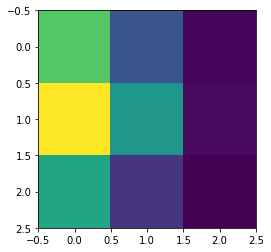

In [68]:
mat = confusion_matrix( true, predicted, labels=[ 'AD', 'AR', 'XL' ] )
plt.imshow( mat )

In [62]:
def classAccuracy( label, predicted, true ):
    predicted_label = predicted[ true == label ]
    return ( predicted_label == label ).sum() / predicted_label.shape[ 0 ]

In [63]:
classAccuracy( 'AD', predicted, true )

0.696969696969697

In [64]:
classAccuracy( 'AR', predicted, true )

0.3401015228426396

In [65]:
classAccuracy( 'XL', predicted, true )

0.030612244897959183

# Well it looks like this approach failed